# About

This notebook used to be much longer but due to a jupytext error my progress was lost :(. It was all on me. Here is the summary of the findings that I got from the old notebook:
- transactions vs. customers:
    - Different time spans, different number of users.
    - Transactions lack some customer_id from the customers set for possibly 2 reasons:
        - No transaction observed for that customer in the observation period.
        - Customers have not started their life spans yet (proven false, all customers have started their life span within 2025).
- Timespan
    - The observation window is smaller than the service window.
    - Observation window: Within 2025.
    - Service window: Within 2025 and 2026.
- Consumer behavior
    - Since the number of purchases is derived from transactions data, the tenure (observation period) is a better indicator of number of purchases than the actual time span.
    - If a customer had a top lifespan, it is more likely that the person will have a top number of purchases too. But if a customer had a medium life span, we are less certain about an amount of purchases within the window -> the distribution of purchases conditoned on medium lifespan is quite discrete.

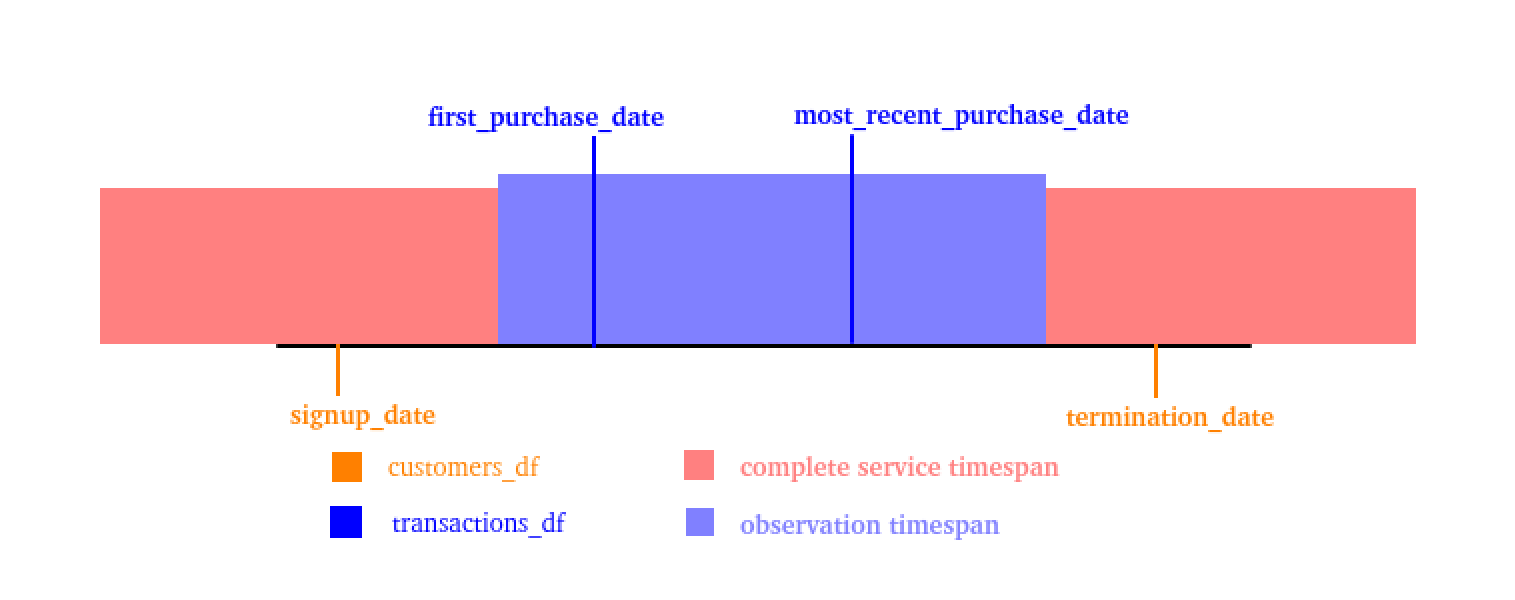

Questions:
- Are there any data abnormalities?
- What is a suitable inactivity window for churn?
- What is the baseline rates? (For benchmarking models later)

# Preparation

## Libraries

In [1]:
import pandas as pd

In [2]:
from dotenv import load_dotenv
import os

In [3]:
import maika_eda_pandas as mk

In [4]:
from src.core.transforms import get_customers_screenshot_summary_from_transactions_df

In [36]:
import plotly.express as px

## Environment

In [5]:
load_dotenv()

True

In [6]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [7]:
OBSERVED_DATE = pd.Timestamp('2025-12-31')

## Data

In [8]:
customers_df = pd.read_csv(f"../{SEED_CUSTOMERS}")

In [9]:
transactions_df = pd.read_csv(f"../{SEED_TRANSACTIONS}")

In [10]:
mk.read_data_info(customers_df)

Number of columns: 3
Column names: ['customer_id', 'signup_date', 'true_lifetime_days']
Number of rows: 3,000
Data Preview: 

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113


In [11]:
mk.read_data_info(transactions_df)

Number of columns: 3
Column names: ['customer_id', 'transaction_date', 'amount']
Number of rows: 46,704
Data Preview: 

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95


# EDA

## customers_df

### Overview

In [12]:
mk.data_overview_table(customers_df)

/home/hong-mai/Desktop/HONGMAI/maike/maika_eda_pandas/maika_eda_pandas.py:166: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,Data Type,Non Null Count,Non Null %,Missing Count,Missing %,Unique Count,Unique %,Zero Count,Negative Count,Zero %,Negative %,Row Count
customer_id,object,"3,000",100.00%,0,0.00%,"3,000",100.00%,0,0,0.00%,0.00%,"3,000"
signup_date,object,"3,000",100.00%,0,0.00%,335,11.17%,0,0,0.00%,0.00%,"3,000"
true_lifetime_days,int64,"3,000",100.00%,0,0.00%,330,11.00%,0,0,0.00%,0.00%,"3,000"


### Transform

In [13]:
customers_df['signup_date'] = pd.to_datetime(customers_df['signup_date'])

In [14]:
customers_df['termination_date'] = customers_df['signup_date'] + pd.to_timedelta(customers_df['true_lifetime_days'], unit='D')

### signup_date

In [15]:
styled_df, fig = mk.frequency_table_and_bar(customers_df, 'signup_date')
styled_df['signup_date'] = styled_df['signup_date'].dt.strftime('%Y-%m-%d')
mk.stack_plotly_figure_with_styled_dataframe(fig, styled_df)

### true_lifetime_days

In [16]:
stat_df = mk.distribution_statistics_table(customers_df, value_col='true_lifetime_days')
fig = mk.create_histogram_plotly(customers_df, 'true_lifetime_days')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

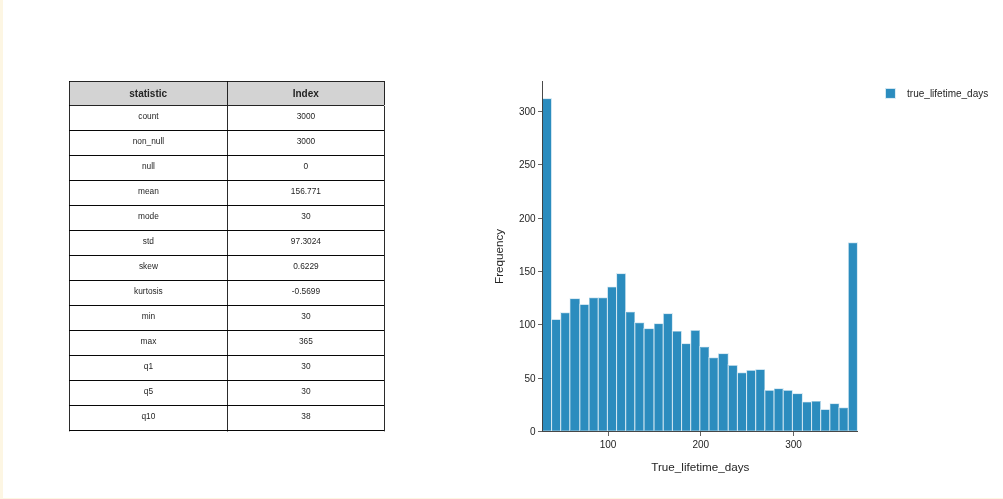

### termination_date

In [43]:
styled_df, fig = mk.frequency_table_and_bar(customers_df, 'termination_date')
styled_df['termination_date'] = styled_df['termination_date'].dt.strftime('%Y-%m-%d')
fig = mk.create_histogram_plotly(customers_df, 'termination_date')
mk.stack_plotly_figure_with_styled_dataframe(fig, styled_df)

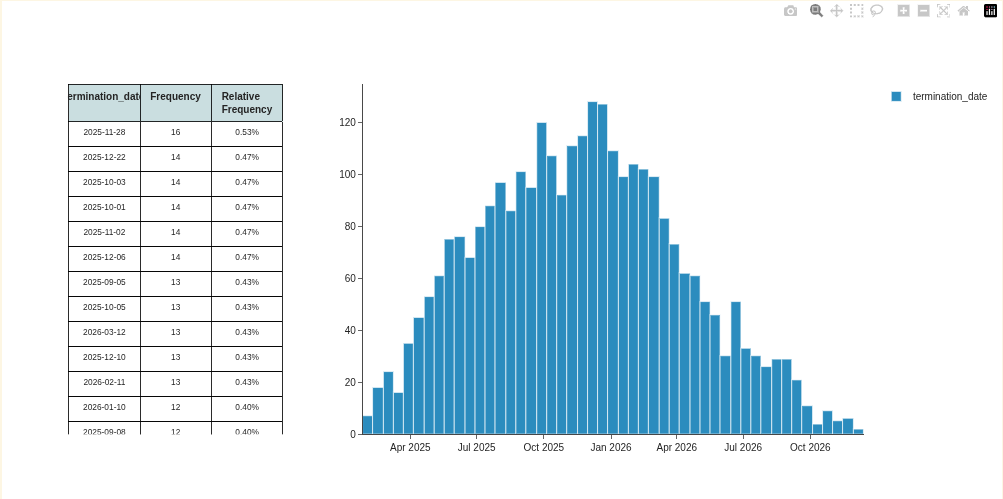

## transactions_df

### Overview

In [18]:
mk.data_overview_table(transactions_df)

/home/hong-mai/Desktop/HONGMAI/maike/maika_eda_pandas/maika_eda_pandas.py:166: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,Data Type,Non Null Count,Non Null %,Missing Count,Missing %,Unique Count,Unique %,Zero Count,Negative Count,Zero %,Negative %,Row Count
customer_id,object,"46,704",100.00%,0,0.00%,"2,892",6.19%,0,0,0.00%,0.00%,"46,704"
transaction_date,object,"46,704",100.00%,0,0.00%,363,0.78%,0,0,0.00%,0.00%,"46,704"
amount,float64,"46,704",100.00%,0,0.00%,"15,059",32.24%,0,0,0.00%,0.00%,"46,704"


### Transform

In [19]:
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

### transaction_date

In [ ]:
styled_df, fig = mk.frequency_table_and_bar(transactions_df, 'transaction_date')
styled_df['transaction_date'] = styled_df['transaction_date'].dt.strftime('%Y-%m-%d')
fig = mk.create_histogram_plotly(transactions_df, 'transaction_date')
mk.stack_plotly_figure_with_styled_dataframe(fig, styled_df)

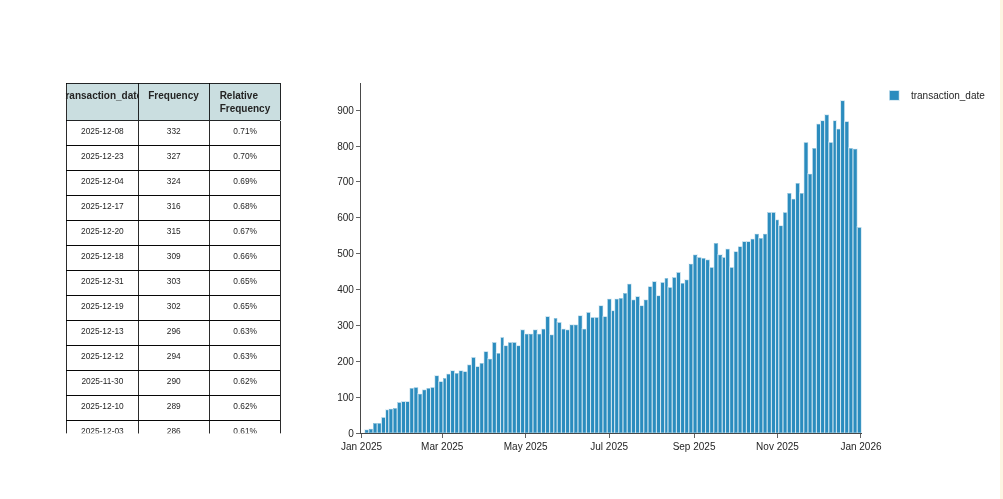

### amount

In [21]:
stat_df = mk.distribution_statistics_table(transactions_df, None, 'amount')
fig = mk.create_histogram_plotly(transactions_df, 'amount')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

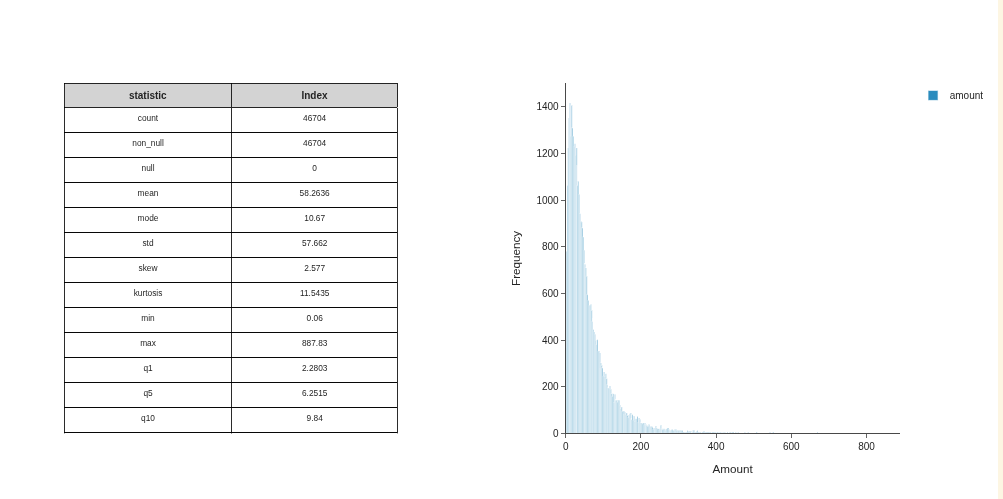

# Data Understanding

## Timespan

In [22]:
data_timespans = {
    'customers': [
        customers_df['signup_date'].min().strftime('%Y-%m-%d'),
        customers_df['signup_date'].max().strftime('%Y-%m-%d')
    ],
    'transactions': [
        transactions_df['transaction_date'].min().strftime('%Y-%m-%d'),
        transactions_df['transaction_date'].max().strftime('%Y-%m-%d')
    ]
}

In [23]:
data_timespans

{'customers': ['2025-01-02', '2025-12-02'],
 'transactions': ['2025-01-03', '2025-12-31']}

## Customer Behavior

## RFM Features

I need to check for the distributions of:
- Recency
- Frequency
- Monetary Values

To choose a suitable method for setting segments.

In [24]:
customers_screenshot_summary_df = get_customers_screenshot_summary_from_transactions_df(
    transactions_df = transactions_df,
    observed_date = OBSERVED_DATE,
    column_names = ['customer_id', 'transaction_date', 'amount']
)

In [25]:
customers_screenshot_summary_df

,customer_id,period_total_amount,period_first_transaction_date,period_last_transaction_date,period_transaction_count,days_until_observed,period_tenure_days
0,C00000,1222.85,2025-09-10,2025-12-31,12,0,112
1,C00001,1228.46,2025-03-17,2025-12-20,19,11,278
2,C00002,910.64,2025-08-20,2025-09-26,11,96,37
3,C00003,114.71,2025-10-04,2025-11-18,4,43,45
4,C00004,2018.94,2025-06-08,2025-09-14,19,108,98
...,...,...,...,...,...,...,...
2887,C02995,460.70,2025-10-23,2025-12-31,15,0,69
2888,C02996,638.36,2025-06-20,2025-11-28,9,33,161
2889,C02997,459.83,2025-11-02,2025-12-26,16,5,54
2890,C02998,1505.03,2025-10-26,2025-12-31,24,0,66


In [26]:
## RECENCY
col_name = 'days_until_observed'
stat_df = mk.distribution_statistics_table(customers_screenshot_summary_df, value_col=col_name)
fig = mk.create_histogram_plotly(customers_screenshot_summary_df, col_name)
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

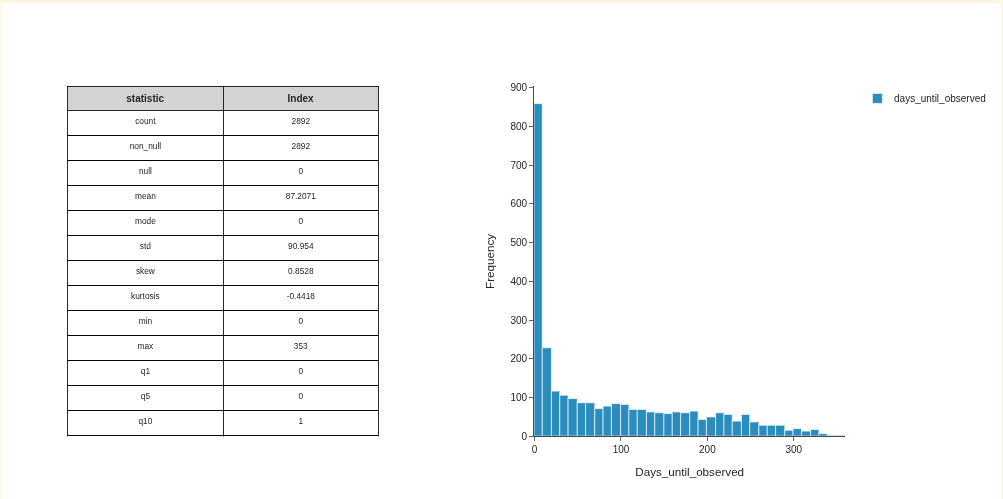

In [27]:
## FREQUENCY
col_name = 'period_transaction_count'
stat_df = mk.distribution_statistics_table(customers_screenshot_summary_df, value_col=col_name)
fig = mk.create_histogram_plotly(customers_screenshot_summary_df, col_name)
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

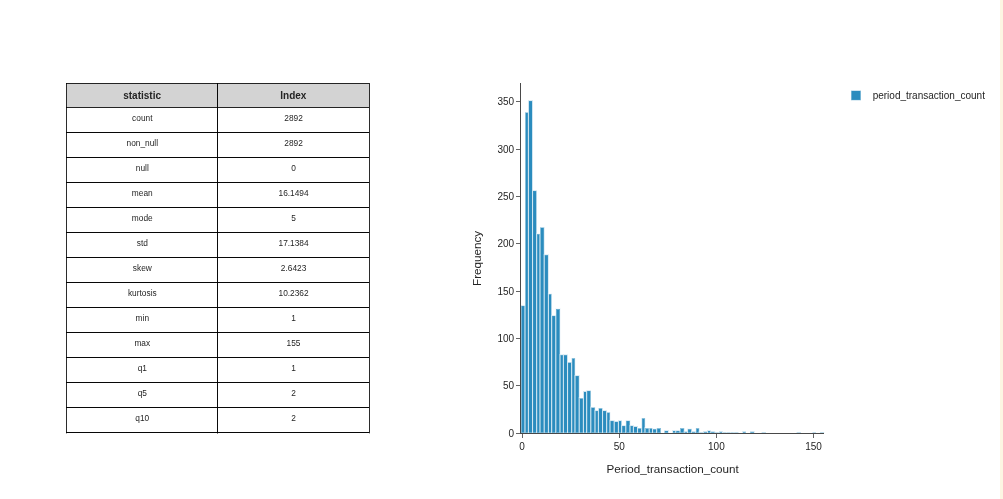

In [28]:
## MONETARY VALUE
col_name = 'period_total_amount'
stat_df = mk.distribution_statistics_table(customers_screenshot_summary_df, value_col=col_name)
fig = mk.create_histogram_plotly(customers_screenshot_summary_df, col_name)
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

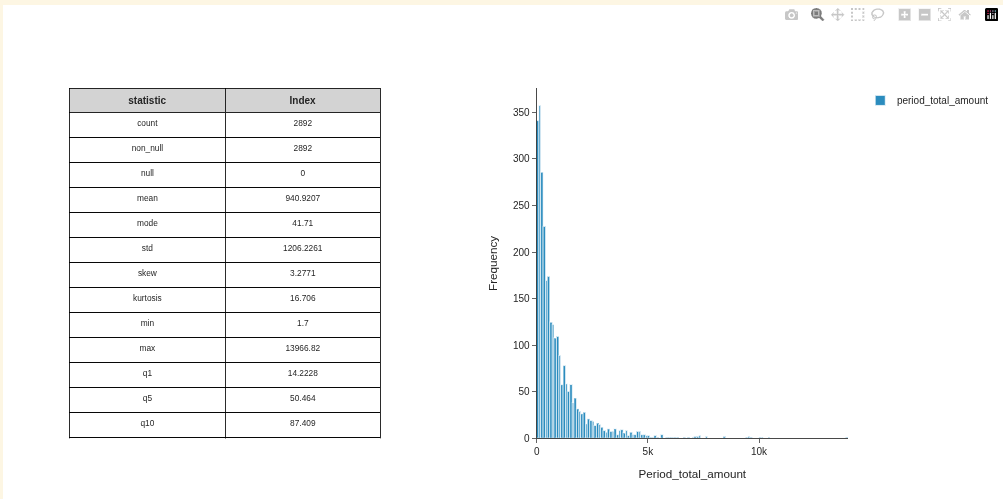

In [29]:
## TENURE
col_name = 'period_tenure_days'
stat_df = mk.distribution_statistics_table(customers_screenshot_summary_df, value_col=col_name)
fig = mk.create_histogram_plotly(customers_screenshot_summary_df, col_name)
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

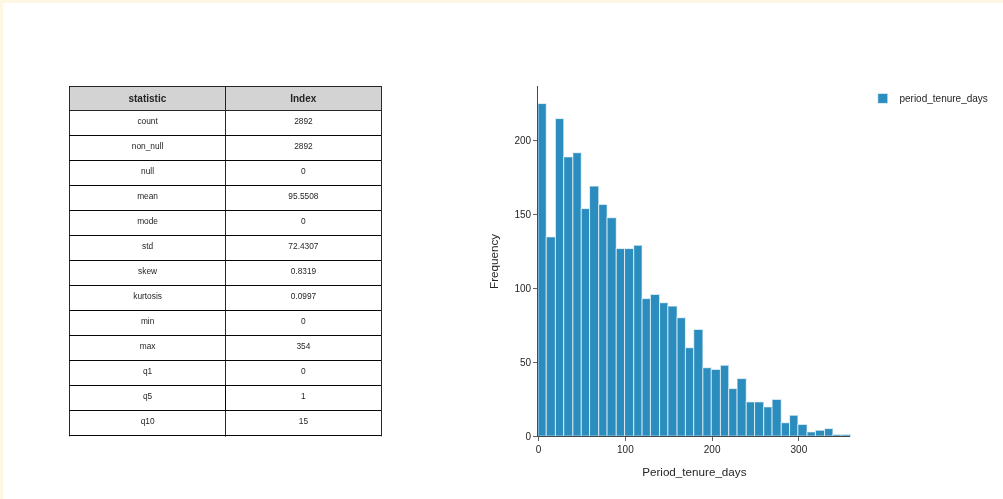

*The tenure part is technically not within RFM, but I'm just investigating for future modelling purposes.

Observation:
- All distributions are skewed (expected), but they are not TOO skewed to the point of not being divisable/segmentable (i.e. 1 purchase is already Q30)
- -> I can use Quantile binning methods.

# Churn Definition

Logic: Because we are lucky enough to have prophetic vision and see customer life spans -> Let's do churn label dynamically based on customer's actual label.
- If customers_obs_df['window_end'] < customers_df['termination_date']: -> label 0 (not churned yet) else label 1 (churned)
Let's assume the observation period ends on 2025-12-31 (based on the transactions data), and we need to predict churn statuses for next periods.

In [30]:
customers_obs_df = customers_df.copy()

In [31]:
OBSERVED_DATE

Timestamp('2025-12-31 00:00:00')

In [32]:
customers_obs_df['is_churn'] = (
    customers_obs_df['termination_date'] <= OBSERVED_DATE
).astype(int)

In [33]:
customers_obs_df

,customer_id,signup_date,true_lifetime_days,termination_date,is_churn
0,C00000,2025-08-22,204,2026-03-14,0
1,C00001,2025-03-07,365,2026-03-07,0
2,C00002,2025-08-18,48,2025-10-05,1
3,C00003,2025-09-22,84,2025-12-15,1
4,C00004,2025-05-28,113,2025-09-18,1
...,...,...,...,...,...
2995,C02995,2025-10-05,303,2026-08-04,0
2996,C02996,2025-06-03,308,2026-04-07,0
2997,C02997,2025-10-23,99,2026-01-30,0
2998,C02998,2025-10-25,174,2026-04-17,0


In [34]:
styled_df, fig = mk.frequency_table_and_bar(customers_obs_df, 'is_churn')
mk.stack_plotly_figure_with_styled_dataframe(fig, styled_df)

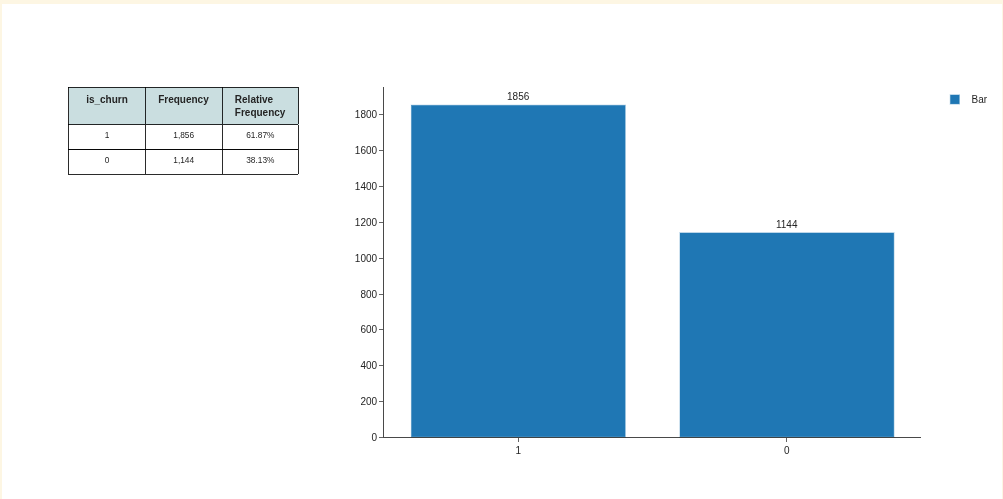

At the observed time, half of the customers have already died. Yikes.